Bridge Asteroids with the Solar System
====================

For reference you can read chapter 7 of Portegies Zwart & McMillan 2018 (2018araa.book.....P). 

In [1]:
%matplotlib inline
import numpy
from matplotlib import pyplot
from amuse.units import units, constants
from amuse.lab import Particles
from amuse.lab import nbody_system
from amuse.couple import bridge

We start by creating the system class in which we describe the background (static) potential of the Solar System.
This is a very simple background potential model, which you can find in [Binney & Trainaine](https://ui.adsabs.harvard.edu/abs/2008gady.book.....B/abstract).

The class definition was quite simple. But the two main routines get_potential_at_point and get_gravity_at_point are the ones that do the job. These routines are used in the integrator the calculate the potential and local gravity at a particular point in space. The format of the argument list of these functions is fixed, because it is used elsewhere in AMUSE for integrating the cluster (which we still have to define).

In [2]:
import numpy as np
import itertools

def arange(l, u, definition = 5):
    '''
    Modified version of the np.arange function be inclusive and generate
    points by a given definition.
    '''
    increment = (u-l)/definition
    return np.arange(l, u+increment-1e-5, increment)


def polygon_area(polygon, normal):
    '''
    Given a polygon and the normal of the plane defined by it, returns its area.
    '''
    total = [0, 0, 0]
    if isinstance(polygon, list):
        polygon = np.array(polygon)

    polygon = polygon[1:] - polygon[0:1]
    N = len(polygon)

    for i in range(N):
        vi1 = polygon[i]
        vi2 = polygon[(i+1) % N]
        prod = np.cross(vi1, vi2)
        total[0] += prod[0]
        total[1] += prod[1]
        total[2] += prod[2]
    result = np.dot(total, normal)
    return abs(result)



class Cube:
    '''
    A class for a cube object to be used as a base for all other shapes of objects.
    '''
    def __init__(self, radius, definition = 5):
        self.cube, self.faces = Cube.generate_cube(radius = radius, definition = definition, return_faces = True)
        self.normals = self.get_normals()

    def __call__(self):
        return self.cube

    @staticmethod
    def generate_cube(radius, definition, return_faces = False):
        '''
        Given a radius (aka. half of side length), generates a cube around (0,0,0).
        Can return the full cube or a list of inidividual faces.
        '''
        _constant = [radius]
        _neg_constant = [-radius]
        _range = arange(-1*radius, radius, definition)

        #Constant x.
        face_1 = np.array(list(itertools.product(_constant, _range, _range)))
        face_2 = np.array(list(itertools.product(_neg_constant, _range, _range)))
        #Constant y.
        face_3 = np.array(list(itertools.product(_range, _constant, _range)))
        face_4 = np.array(list(itertools.product(_range, _neg_constant, _range)))
        #Constant z.
        face_5 = np.array(list(itertools.product(_range, _range, _constant)))
        face_6 = np.array(list(itertools.product(_range, _range, _neg_constant)))

        cube = np.vstack((face_1, face_2, face_3, face_4, face_5, face_6))

        if return_faces:
            return cube, [face_1, face_2, face_3, face_4, face_5, face_6]

        else:
            return cube

    def get_face_normals(self, face):
        '''
        Given a face of a cube, returns the bases and the tips of all normal vectors on that face.
        '''
        x = np.unique(face.T[0])
        y = np.unique(face.T[1])
        z = np.unique(face.T[2])

        bin_size = (x[1] - x[0])/2 if len(x) > 1 else (y[1] - y[0])/2

        if len(x) == 1:
            norm_centers = np.array(list(itertools.product(x, y[:-1]+bin_size, z[:-1]+bin_size)))
            norm_tips = norm_centers + np.tile(np.array([x[0]/np.abs(x[0]), 0, 0]), (norm_centers.shape[0], 1))

        elif len(y) == 1:
            norm_centers = np.array(list(itertools.product(x[:-1]+bin_size, y, z[:-1]+bin_size)))
            norm_tips = norm_centers + np.tile(np.array([0, y[0]/np.abs(y[0]), 0]), (norm_centers.shape[0], 1))

        elif len(z) == 1:
            norm_centers = np.array(list(itertools.product(x[:-1]+bin_size, y[:-1]+bin_size, z)))
            norm_tips = norm_centers + np.tile(np.array([0, 0, z[0]/np.abs(z[0])]), (norm_centers.shape[0], 1))

        return norm_centers, norm_tips


    def get_normals(self, return_points = False):
        '''
        Given a cube, returns all of the normal vectors for all of the individual facets.
        Can additionally return the base points of all normals.
        '''
        _centers = []
        _tips = []

        for face in self.faces:
            centers, tips = self.get_face_normals(face)
            _centers.append(centers)
            _tips.append(tips)

        _centers = np.array(_centers).reshape(np.array(_centers).shape[0]*np.array(_centers).shape[1], np.array(_centers).shape[2])
        _tips = np.array(_tips).reshape(np.array(_tips).shape[0]*np.array(_tips).shape[1], np.array(_tips).shape[2])

        normals = _tips - _centers

        row_sums = np.array([np.linalg.norm(row) for row in normals])
        normals = np.array(normals / row_sums[:, np.newaxis])

        if return_points:
            return _centers, _tips

        else:
            return normals

    def get_patches(self, face):
        '''
        Given a face of a cube, returns the arrays of corners of individual patches.
        '''
        x = np.unique(face.T[0])
        y = np.unique(face.T[1])
        z = np.unique(face.T[2])

        bin_size = (x[1] - x[0]) if len(x) > 1 else (y[1] - y[0])

        if len(x) == 1:
            patches = []
            for point in itertools.product(x, y[:-1], z[:-1]):
                _p0 = np.array(list(point))
                _p1 = _p0 + np.array([0, bin_size, 0])
                _p2 = _p0 + np.array([0, 0, bin_size])
                _p3 = _p0 + np.array([0, bin_size, bin_size])
                patches.append([_p0, _p1, _p2, _p3])

        if len(y) == 1:
            patches = []
            for point in itertools.product(x[:-1], y, z[:-1]):
                _p0 = np.array(list(point))
                _p1 = _p0 + np.array([bin_size, 0, 0])
                _p2 = _p0 + np.array([0, 0, bin_size])
                _p3 = _p0 + np.array([bin_size, 0, bin_size])
                patches.append([_p0, _p1, _p2, _p3])

        if len(z) == 1:
            patches = []
            for point in itertools.product(x[:-1], y[:-1], z):
                _p0 = np.array(list(point))
                _p1 = _p0 + np.array([bin_size, 0, 0])
                _p2 = _p0 + np.array([0, bin_size, 0])
                _p3 = _p0 + np.array([bin_size, bin_size, 0])
                patches.append([_p0, _p1, _p2, _p3])

        return patches

    def get_areas(self):
        '''
        Given a a cube, return the areas of the individual polygons on all faces and the normal associated.
        '''
        result = []

        for face in self.faces:
            patches = self.get_patches(face)
            for patch in patches:
                patch = np.array(patch)
                patch_normal_center, patch_normal_tip = self.get_face_normals(patch)
                patch_normal = patch_normal_tip - patch_normal_center
                patch_area = polygon_area(patch, patch_normal.squeeze())
                result.append([patch_area, patch_normal])

        return result



class Sphere(Cube):
    '''
    A sphere object built from a cube of same radius.
    '''
    def __init__(self, radius, definition = 5):
        self.sphere = self.generate_sphere(radius, definition)
        self.normals = self.get_sphere_normals()

    def __call__(self):
        return self.sphere

    @staticmethod
    def cube2sphere(vector):
        '''
        Convert from the surface of a cube to a sphere of same radius.
        Radius is determined automatically.
        '''
        x = vector.T[0]
        y = vector.T[1]
        z = vector.T[2]

        r_x = max(abs(x))
        r_y = max(abs(y))
        r_z = max(abs(z))
        r = max(r_x, r_y, r_z)

        #    r_x = abs(max(x) - min(x))
        #    r_y = abs(max(y) - min(y))
        #    r_z = abs(max(z) - min(z))
        #    r = max([r_x, r_y, r_z])/2

        x_ = r**(-1) * x * (r**2 - (y**2/2) - (z**2/2) + (y**2*z**2/(3*r**2)))**0.5
        y_ = r**(-1) * y * (r**2 - (x**2/2) - (z**2/2) + (x**2*z**2/(3*r**2)))**0.5
        z_ = r**(-1) * z * (r**2 - (x**2/2) - (y**2/2) + (x**2*y**2/(3*r**2)))**0.5

        return np.vstack((x_, y_, z_)).T

    def generate_sphere(self, radius, definition):
        self.cube, self.faces = Cube.generate_cube(radius, definition, return_faces = True)
        return Sphere.cube2sphere(self.cube)

    def get_sphere_normals(self, cube_face = None, return_centers = False):
        '''
        Given a sphere, returns all of the normal vectors for the all of the individual facets.
        Can additionally return the base points of all normals.
        '''
        if cube_face is None:
            cube_centers, cube_tips = self.get_normals(return_points = True)
        else:
            cube_centers, cube_tips = self.get_face_normals(cube_face)

        sphere_centers = self.cube2sphere(cube_centers)
        sphere_tips = self.cube2sphere(cube_tips)

        #sphere_normals = sphere_tips - sphere_centers #This does not work as the normal is not preserved.
        sphere_normals = sphere_centers

        row_sums = np.array([np.linalg.norm(row) for row in sphere_normals])
        sphere_normals = np.array(sphere_normals / row_sums[:, np.newaxis])

        if return_centers:
            return sphere_normals, sphere_centers

        else:
            return sphere_normals

    def get_sphere_areas(self):
        '''
        The area calculation counterpart for the sphere.
        '''
        result = []

        for face in self.faces:
            patches = self.get_patches(face)
            for patch in patches:
                patch = np.array(patch)
                sphere_patch = Sphere.cube2sphere(patch)

                sphere_patch_normal, sphere_patch_center = self.get_sphere_normals(cube_face = patch, return_centers = True)
                sphere_patch_normal = sphere_patch_normal.squeeze()
                sphere_patch_center = sphere_patch_center.squeeze()

                sphere_patch_area = polygon_area(sphere_patch, sphere_patch_normal)
                result.append([sphere_patch_center, sphere_patch_normal, sphere_patch_area])

        return result


In [3]:
import numpy as np
from amuse.lab import Particle
from amuse.lab import constants
from amuse.units import units as u 

# cube_sphere import Sphere

class Asteroid(Particle):
    '''
    A subclass of the AMUSE Particle with added functionality for asteroids.

    Inputs:

    Variables:
    (from amuse.lab.Particle)
    - position : [x, y, z] spatial coordinates of the object.

    - tesselations: a list of patches [center, normal, area, temperature, albedo] defining the surface tesselation of the asteroid.
    '''
    def __init__(self, radius, definition = 10, key=None, particles_set=None, set_index=None, set_version=-1, **keyword_arguments):
        super().__init__(key, particles_set, set_index, set_version, **keyword_arguments)        
        self.radius = radius

        tessellations = Sphere(self.radius.value_in(u.m), definition = definition).get_sphere_areas()
        for face in tessellations:
            face += [0, 0, 0] #To store temperature, albedo, emissivity.
        tessellations = np.array(tessellations, dtype=object)

        object.__setattr__(self, "tessellations", tessellations)
        
        self.get_albedo_emissivity()
    
    def get_albedo_emissivity(self, albedo_array = None, emissivity_array = None):
        '''
        Either automatically initialize the surface emissivity and albedo, or import them from array.

        Inputs:
        - albedo_array: an array of albedo values with same length as the number of tessellations. Manual input or auto-generated.
        - emissivity_array: an array of emissivity values with same length as the number of tessellations. Manual input or auto-generated.

        Returns:
        None
        '''
        if not albedo_array: 
            self.tessellations[:,4] = np.random.uniform(0,1,len(self.tessellations[:,4]))
        else:
            self.tessellations[:,4] = albedo_array   
        if not emissivity_array:
            self.tessellations[:,5] = np.array([0.65]*len(self.tessellations[:,5]))
        else:
            self.tessellations[:,5] = emissivity_array

    def get_acceleration(self, star_direction, star):
        '''
        Given the direction to and the star in the system, calculates the Yarkovsky (and YORP) forces on the asteroid through iterating over 
        its own tesselated surface and returns the accelerations per spatial coordinate.

        Inputs:
        - star_direction: as defined in System.get_directions.
        - star: as defined in System variables.
        
        Returns:
        - acceleration: the total accelerations ax, ay, az on the asteroid.
        '''
        total_force = np.zeros(3) | u.m * u.kg * u.s**-2
        for patch in self.tessellations:
            #Define the variables. Ugly...
            center = patch[0]
            normal = patch[1]
            area = patch[2] | u.m**2
            temperature = None
            albedo = patch[4]
            emissivity = patch[5]
            
            #Calculate off-axis factor. If this number is less than 0, it means the patch is invisible from the star.
            mu_0 = np.dot(star_direction, normal)
            if mu_0 < 0:
                mu_0 = 0

            #Calculate incident flux.
            star_dist = np.linalg.norm(star.position-self.position)
            incident_flux = star.luminosity / (4*np.pi*star_dist**2)

            #Calculate and log the patch temperature.
            temperature = (((1-albedo)*mu_0*incident_flux)/(emissivity*constants.Stefan_hyphen_Boltzmann_constant))**(1/4)
            patch[3] = temperature
            
            #Calculate the scattering force.
            scattering_force = -(2/3) * (mu_0 * albedo * incident_flux / constants.c) * area * normal
            total_force += scattering_force

            #Calculate the thermal force.
            thermal_force = -(2/3) * (emissivity * constants.Stefan_hyphen_Boltzmann_constant \
                                      * temperature**4 / constants.c) * area * normal
            total_force += thermal_force

            #Return accelerations. Account for the the zero point float.
            zero_float = 5.45e-14 | u.m * u.s**-2
            zero = 0 | u.m * u.s**-2

            ax = total_force[0]/self.mass if np.abs(total_force[0]/self.mass) > zero_float else zero 
            ay = total_force[1]/self.mass if np.abs(total_force[1]/self.mass) > zero_float else zero 
            az = total_force[2]/self.mass if np.abs(total_force[2]/self.mass) > zero_float else zero 
            
        return ax, ay, az 

    def get_flux(self, obs_direction, star_direction, observer, star):
        '''
        Given the directions and the observer and star in the system, calculates the flux observed by the observer through iterating 
        over its own tesselated surface.

        Inputs:
        - obs_direction: as defined in System.get_directions.
        - star_direction: as defined in System.get_directions.
        - observer: as defined in System variables.
        - star: as defined in System variables.

        Returns:
        - flux: the total flux observed by the observer.
        '''
        total_flux = 0 | u.kg * u.s**-3 
        for patch in self.tessellations:
            #Define the variables. Ugly...
            center = patch[0]
            normal = patch[1]
            area = patch[2] | u.m**2
            temperature = None
            albedo = patch[4]
            emissivity = patch[5]
            
            #Calculate off-axis factor. If this number is less than 0, it means the patch is invisible from the star.
            mu_0 = np.dot(star_direction, normal)
            if mu_0 < 0:
                mu_0 = 0 

            #Calculate the incident flux.
            star_dist = np.linalg.norm(star.position-self.position)
            incident_flux = star.luminosity / (4*np.pi*star_dist**2)

            #Calculate and log the patch temperature.
            temperature = (((1-albedo)*mu_0*incident_flux)/(emissivity*constants.Stefan_hyphen_Boltzmann_constant))**(1/4)
            patch[3] = temperature
            
            #Calculate the received flux due to re-emitted radiation. 
            obs_dist = np.linalg.norm(observer.position-self.position)
            re_emitted_flux = constants.Stefan_hyphen_Boltzmann_constant * area * temperature**4 / (2*np.pi*obs_dist**2)
            re_emitted_flux = re_emitted_flux * np.dot(obs_direction, normal)
            total_flux += re_emitted_flux
            
            #Define the reflection reception criterion.
            def reflection_reception(v1, v2, observer):
                observer_size = 2000 | u.REarth 
                obs_dist = np.linalg.norm(observer.position-self.position)
                angle = np.arctan(observer_size/obs_dist)
                return bool(np.arctan(np.dot(v1, v2)) < angle)

            #Calculate the received flux due to reflected radiation.
            reflected_flux = incident_flux * albedo
            reflected_direction = star_direction - 2*np.dot(-star_direction,normal)*normal 
            if reflection_reception(obs_direction, reflected_direction, observer):
                total_flux += reflected_flux
                
        return total_flux

In [4]:
from amuse.units import units as u
from amuse.units import constants as c
from amuse.lab import Particles
import numpy as np

#from asteroid import Asteroid

def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

def pol2cart(r, phi):
    x = r * np.cos(phi)
    y = r * np.sin(phi)
    return(x.in_(u.au), y.in_(u.au), 0|u.au)

class System:
    '''
    A class to house all the bodies in a solar system.

    Inputs:
    - system_info: a configuration .json file that details the particular system to be created.

    Returns:

    Variables:
    - stars: the AMUSE particles objects belonging to the stars in the solar system.
    - planets: the list of all AMUSE particles objects belonging to the planets in the solar system.
    - asteroids: the list of all Asteroid class objects in the system.
    - observer: the location of the observer in the system.
    - observables: the list of all objects in the asteroids that are to be observed.
    - light_curve: the list of all flux calculations stored by calculate_flux for all observables.
    '''

    def __init__(self, system_info):
        '''
        Initializes the solar system with all of its objects. Assumes coplanar orbits.

        Inputs:
        - system_info: as defined in the class input.

        Returns:
        - System: a system class object.
        '''
        self.stars = Particles(len(system_info["stars"]))
        self.planets = Particles(len(system_info["planets"]))
        self.asteroids = [Asteroid(system_info["asteroids"]["Bennu"]["radius"])]
        
        particle_sets = {"stars" : self.stars, 
                         "planets" : self.planets,
                         "asteroids" : self.asteroids}

        self.light_curve = []
        
        # Update properties that are shared by all bodies.
        for idx in system_info:
            bodies, bodies_info = particle_sets[idx], system_info[idx]
            for i, body in enumerate(bodies_info):
                bodies[i].name   = bodies_info[body]["name"]
                bodies[i].mass   = bodies_info[body]["mass"]
                bodies[i].radius = bodies_info[body]["radius"]
                bodies[i].position = pol2cart(bodies_info[body]["semimajor_axis"], 
                                              bodies_info[body]["orbital_phase"])
        
        def relative_orbital_velocity(mass, distance):
            return (c.G*mass/distance).sqrt()
        
        for star in self.stars:
            if len(self.stars) > 1:
                norm = (np.linalg.norm(star.position)).in_(u.au)
                vorb = relative_orbital_velocity(self.stars.mass.sum(), 
                                                 star.position.length())
                star.vx = -star.y * vorb / norm
                star.vy =  star.x * vorb / norm
                star.vz =  star.z * vorb / norm
            else:
                star.velocity = (0,0,0) | u.m * u.s**-1
            star.luminosity = system_info["stars"][star.name]["luminosity"]
        
        for planet in self.planets:
            #This assumes that the system's center of mass is at [0,0,0]
            norm = (np.linalg.norm(planet.position)).in_(u.au)
            vorb = relative_orbital_velocity(self.stars.mass.sum()+planet.mass, 
                                             planet.position.length())
                                        
            planet.vx = -planet.y * vorb / norm
            planet.vy =  planet.x * vorb / norm
            planet.vz =  planet.z * vorb / norm
        
        for asteroid in self.asteroids:
            #This assumes that the system's center of mass is at [0,0,0]
            norm = (np.linalg.norm(asteroid.position)).in_(u.au)
            vorb = relative_orbital_velocity(self.stars.mass.sum()+asteroid.mass, 
                                             asteroid.position.length())
                                             
            asteroid.vx = -asteroid.y * vorb / norm
            asteroid.vy =  asteroid.x * vorb / norm
            asteroid.vz =  asteroid.z * vorb / norm
        #Merge these three categories later, when they get evolved
        # should we move them to the center of mass somewhere? do the three need to be merged for that?
        
        #Assume the first planet is the observer by default.
        self.observer = self.planets[0] 
        self.observable = self.asteroids[0]
        
        self.semimajor_axes = np.array([[]]) #| u.au
        self.accelerations = np.array([[0,0,0]]) #| u.m * u.s**-2
    
    def get_directions(self, coord):
        '''
        Given a coordinate in space, returns the vector direction to the observer 
        and the star in the system. Assumes a single star.

        Inputs:
        - coord: an [x, y, z] coordinate in space.

        Returns:
        - obs_direction: the direction to the observer, normalised.
        - star_direction: the direction to the star, normalised. 
        '''
        try:
            coord = coord.in_(u.au)
        except:
            raise ValueError("The coordinate should have a distance unit.")
        
        obs_direction = self.observer.position - coord
        star_direction = self.stars[0].position - coord

        return obs_direction / (np.linalg.norm(obs_direction)).in_(u.au), \
              star_direction / (np.linalg.norm(star_direction)).in_(u.au)
    
    def calculate_flux(self, observable):
        '''
        Given an observable object, calculates the resultant total flux as 
        observed by the observer thorough calling get_direction and 
        subsequently Asteroid.get_flux. Stores the values in light_curve.

        Inputs:
        - observable: an Asteroid class observable object.

        Returns:
        '''
        obs_direction, star_direction = self.get_directions(observable.position)
        flux = observable.get_flux(obs_direction, star_direction, self.observer, self.stars[0])
        self.light_curve.append(flux)

        return
        

    def get_gravity_at_point(self, eps, x, y, z): #Major rewrite necessary.
        '''
        The function to be called by the bridge to calculate accelerations on all observable objects. 
        Proceed as:
        Shape the inputs to [x, y, z] per observable.
        Update asteroid position with the coordinates.
        Calculate acceleration per asteroid in [ax, ay, az] format using Asteroid.get_acceleration per asteroid.
        Reshape to individual ax, ay, az and return.

        Inputs:
        - eps : a length parameter coming from the gravity solver, dummy variable.
        - x : the x-coordinates of observables coming from the gravity solver.
        - y : the y-coordinates of observables coming from the gravity solver.
        - z : the z-coordinates of observables coming from the gravity solver.

        Returns:
        - ax: the x-accelerations of all objects.
        - ay: the y-accelerations of all objects.
        - az: the z-accelerations of all objects.
        '''
        #Update the location of the position coming from the simulation.
        self.observable.position = (x, y, z)

        #Calculate directions and acceleration.
        _, star_direction = self.get_directions(self.observable.position)
        acc = self.observable.get_acceleration(star_direction, self.stars[0])
        self.accelerations = np.append(self.accelerations, [[acc[0].number, acc[1].number, acc[2].number]], axis=0)
        
        sma = np.sqrt( x**2 + y**2 + z**2 )
        self.semimajor_axes = np.append(self.semimajor_axes, sma[0].number)
        
        factor = 1
        #print(acc[0]*factor, acc[1]*factor, acc[2]*factor)
        return acc[0]*factor, acc[1]*factor, acc[2]*factor
        

In [5]:
system_info = {
    "stars" : { 
        "Sun" : {
            "name"     : "Sun",
            "mass"     : 1 | u.MSun,
            "radius"   : 1 | u.RSun,
            "semimajor_axis" : 0 | u.au,
            "orbital_phase" : 0,
            "luminosity" : 1 | u.LSun,
            },
        },
    
    "planets" : { 
        "Earth" : {
            "name"     : "Earth",
            "mass"     : 1 | u.MEarth,
            "radius"   : 1 | u.REarth,
            "semimajor_axis" : 1 | u.au,
            "orbital_phase" : np.pi/4,
            },
        
        "Jupiter" : {
            "name"     : "Jupiter",
            "mass"     : 1 | u.MJupiter,
            "radius"   : 1 | u.RJupiter,
            "semimajor_axis" : 5 | u.au,
            "orbital_phase" : np.pi/6,
            },
        
        },
    
    "asteroids" : {
        "Bennu" : {
            "name"     : "Bennu",
            "mass"     : 73e9 | u.kg,
            "radius"   : 1|u.REarth, #0.24 | u.km,
            "semimajor_axis" : 1.126 | u.au,
            "orbital_phase" : np.pi/4,
            },
        }
    }

system = System(system_info)

In [6]:
def relative_orbital_velocity(mass, distance):
    return (constants.G*mass/distance).sqrt()

ast = Particles(1)
A = ast[0]
A.mass = 10**(14) | units.kg
A.position = (1.0,0,0) * (3 | units.au)
#A.mass = 1 | units.MEarth
#A.position = (1.0, 0, 0) * (1 | units.au)
vorb = relative_orbital_velocity(A.mass + (1 | units.MSun), A.position.sum())
A.velocity = (0, -1, 0) * vorb

sun = Particles(1)
S = sun[0]
S.mass = 1 | units.MSun
S.position = (0, 0, 0) | units.au
S.velocity = (0, 0, 0) | units.kms

#B = ast[1]
#B.mass = 10**(14) |units.kg
#B.position = (1.0,0,0) * (4.01 | units.AU)
#B.velocity = (0,-1.0,0) * (20 | units.ms)

ast_converter=nbody_system.nbody_to_si(ast.mass.sum(), 
                                   ast.position.length())

sun_converter=nbody_system.nbody_to_si(sun.mass.sum(), 
                                   1|units.yr)

The single star has a mass, position and velocity. We can now initiate the N-body code, which is not different than what we have already seen.

In [7]:
from amuse.community.hermite.interface import Hermite
ast_gravity_code = Hermite(ast_converter)
ast_gravity_code.particles.add_particles(ast)
ch_g2l = ast_gravity_code.particles.new_channel_to(ast)

sun_gravity_code = Hermite(sun_converter)
sun_gravity_code.particles.add_particles(sun)
#ch_g2s = sun_gravity_code.particles.new_channel_to(sun)

We not initialize the Milky-way back-ground potential code

In [8]:
#SSG = SolarSystemGravity()
#system = System(system_info)

And the bridge.
The latter, in the next snippet, is like an integrator, except that it takes two or more codes to integrate with respect to each other.
In this case we initalize the bridge and then add a system (the N-body system) to it. It is being perturbed by the Milky Way galaxy code, which we add as the second argument (in a list of length one; there can be multiple perturbing codes). Since there are no particles in the Milky way, they do not require any interaction (they do not need to be updated). For this reason we do not need to add it as a separate system.

Eventually, we provide a timestep to the bridge. This is the time-scale in which the two systems are integrated. Regretfully, and this is one of the major disadvantages of *bridge* its timestep has to be set separately. Of course, this can be done automatically in the script, but sometimes it requires some fine-tuning and pre-knowledge in order to find the optimium between perserving energy while integrating the equations of motion and the speed of the calculation.

In [9]:
gravity = bridge.Bridge(use_threading=False)
gravity.add_system(ast_gravity_code, (sun_gravity_code,) )
gravity.add_system(ast_gravity_code, (system,))
gravity.timestep = 0.25|units.yr

times = numpy.arange(0, 20, 0.25) | units.yr
Ax = [] | units.au
Ay = [] | units.au
Sx = [] | units.au
Sy = [] | units.au
sma = [] | units.au
for time in times:
    if not time.value_in(u.yr)%5:
        print(time)
    gravity.evolve_model(time)
    ch_g2l.copy()
    #ch_g2s.copy()
    Ax.append(ast[0].x)
    Ay.append(ast[0].y)
    
    Sx.append(sun[0].x)
    Sy.append(sun[0].y)
    sma.append( np.sqrt( (ast[0].x-sun[0].x)**2 + (ast[0].y-sun[0].y)**2) )
gravity.stop()

0.0 yr
5.0 yr
10.0 yr
15.0 yr


And we plot the results.

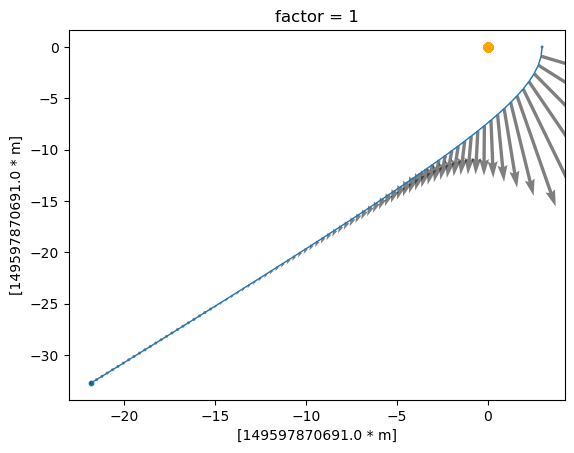

Text(0.5, 0, 'time [years]')

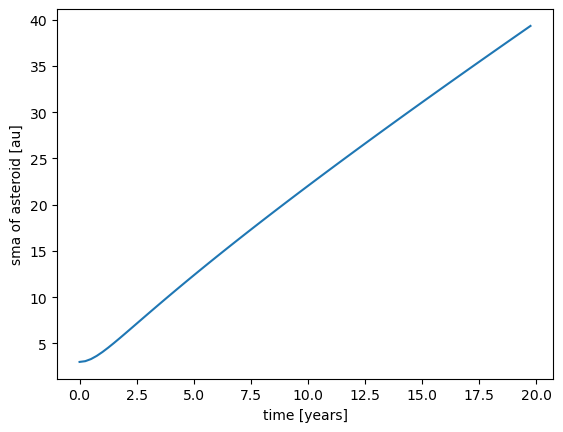

In [12]:
from amuse.plot import plot, scatter
import matplotlib.pyplot as plt

accx = system.accelerations[:,0]
accy = system.accelerations[:,1]
accz = system.accelerations[:,2]

scatter(A.x, A.y, s=10)
plot(Ax, Ay, lw=1)
scatter(Sx, Sy, color='orange')
#pyplot.xlim(-6, 6)
#pyplot.ylim(-6, 6)
#plot(Bx, By, lw=1)
#pyplot.gca().set_aspect("equal", adjustable="box")
pyplot.title("factor = 1")
plt.quiver(Ax.number, Ay.number, accx[::2], accy[::2], alpha=.5)
plt.show()

#plt.plot(times.number, accx[::2], label='acceleration (x)')
#plt.plot(times.number[:-1], system.semimajor_axes[::2]/1e24, label='semimajor axis')
#plt.legend()
#plt.xlabel("time")
#plt.show()

plot(times, sma)
pyplot.ylabel("sma of asteroid [au]")
pyplot.xlabel("time [years]")

It looks like we can integrate the orbit of a single star around the Galactic center, and with an orbital velocity of 200 km/s the orbit turns out to be circular (or close enough to being circular).

Now, we used a direct N-body code (Hermite) for integrating the single star, which is a bit silly. Of course, we only need to update the star's position and velocity in the potential and integrate those. So long as there are no other stars around, there is no need for a direct N-body code.

On the other hand, the N-body code offers us the opportunity to integrate a cluster of stars, rather than just a single star. In this way, we can study the evolution of a cluster in the Galactic potential.

Assignments and questions:
---------------

### Assignment 1:
The output of the figure is not a nice smooth orbit, but a bit jagged. Change the script in such a way that the orbit becomes more smooth.

### Assignment 2:
The integration was for an (almost) circular orbit. Sometimes, however, we are interested in more eccentric orbits.
Integrate the orbit of the same star (at a starting distance of 8.5kpc from the Galactic center), but with a velocity in the *y*-direction of *22km/s*.

### Question 1:
If your star escaped the potentical of the Galaxy, why is that the case. What change do you have to make to the script to assure that the orbit is still correct?

### Question 2:
Can you describe the orbit of the star in the eccentric orbit around the Galactic center?

### Assignment 2:
Replace the single star with a cluster of 10 stars with masses from the Salpeter mass function (between 1MSun and 100Msun) in a Plummer sphere with a characteristic radius of 10pc. Run the simulation and plot the cluster center-of-mass while it orbits the Galactic center.

### Question 3: 
Describe how the cluster center-of-mass orbit differs compared to the orbit of the single star.

### Question 4:
Does the cluster stay bound?

### Assignment 3:
Now change the orbital velocity of the cluster center-of-mass to 22km/s, as you did before in assignment 2, and redo the calculation.
Run the script again and describe how different the cluster orbit is now compared to the orbit of the single star.

### Question 5:
At what point in time does the cluster become unbound?

### Assignment 4:
Redo the calculation of the cluster with 10 stars in an eccentric orbit around the Galactic center, but with a slightly different orbital velocity for each calculation, ranging from 22km/s, 44km/s, 66km/s, up to 440km/s.

While doing the calculation plot the shortest distance of the cluster center to the Galactic center and measure the moment the cluster becomes unbound.

 - Plot the distance of closest approach as a function of the initial orbital velocity of the cluster.
 
 - Plot the moment the cluster dissolves as a function of its initial orbital velocity.

**Make sure that you use the same cluster for each calculation.**

### Question 6:
At what speed does the cluster escape the Galaxy?
And show with theoretical arguments that you could have expected this to happen at that particular speed.

### Question 7:
Explain the curve from plotting the cluster dissolution time as function of its orbital velocity in the Galactic potential.